In [1]:
source("../../wwa/00_model-fitting/wwa_model-fitting.R")

prep_window <- function(rc = c(1,1), w = 4, h = 4) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20) }

### **Load data**

In [2]:
gmst <- read.fwf("/home/clair/wwa/90_data/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 1900]

tmean <- read.fwf("data/CET-tmean-daily.txt", widths = c(10,7), skip = 1, col.names = c("date", "tmean"))
max_tmean = blockmaxxer(tmean, which = "tmean", blocks = as.factor(substr(tmean$date,1,4)))
max_tmean$year <- substr(max_tmean$date,1,4)
max_tmean <- max_tmean[max_tmean$year < 2023,]

df <- merge(gmst, max_tmean)

### **Transient method**

In [30]:
# fit both models
gev_shift <- fit_ns("gev", "shift", df, "tmean", "gmst", lower = F)
gev_fd <- fit_ns("gev", "fixeddisp", df, "tmean", "gmst", lower = F)

# almost no change in the log-likelihood
gev_shift$value
gev_fd$value

[1] 269.7669

[1] 269.4388

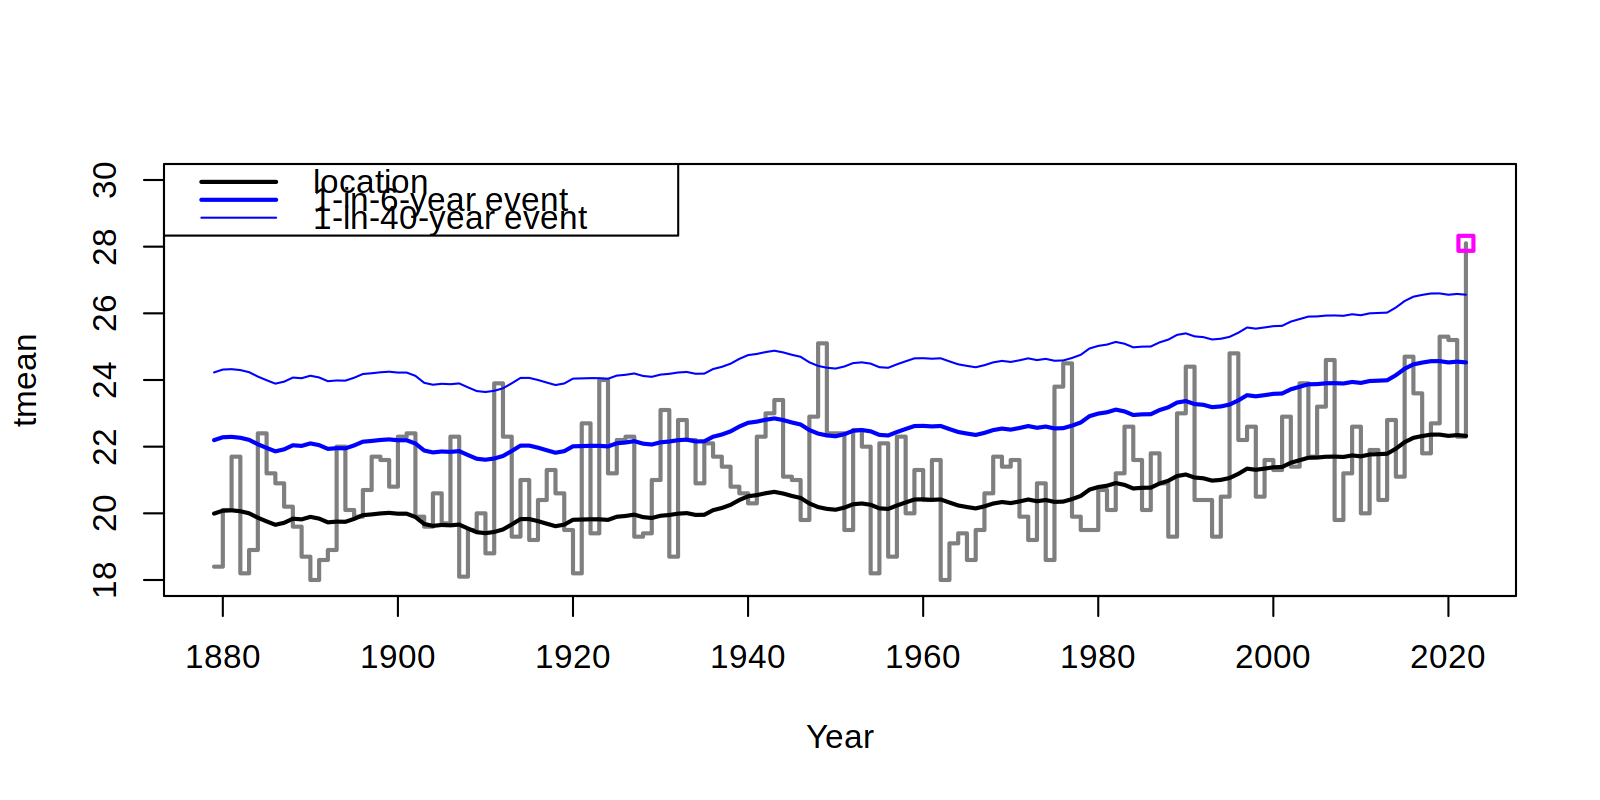

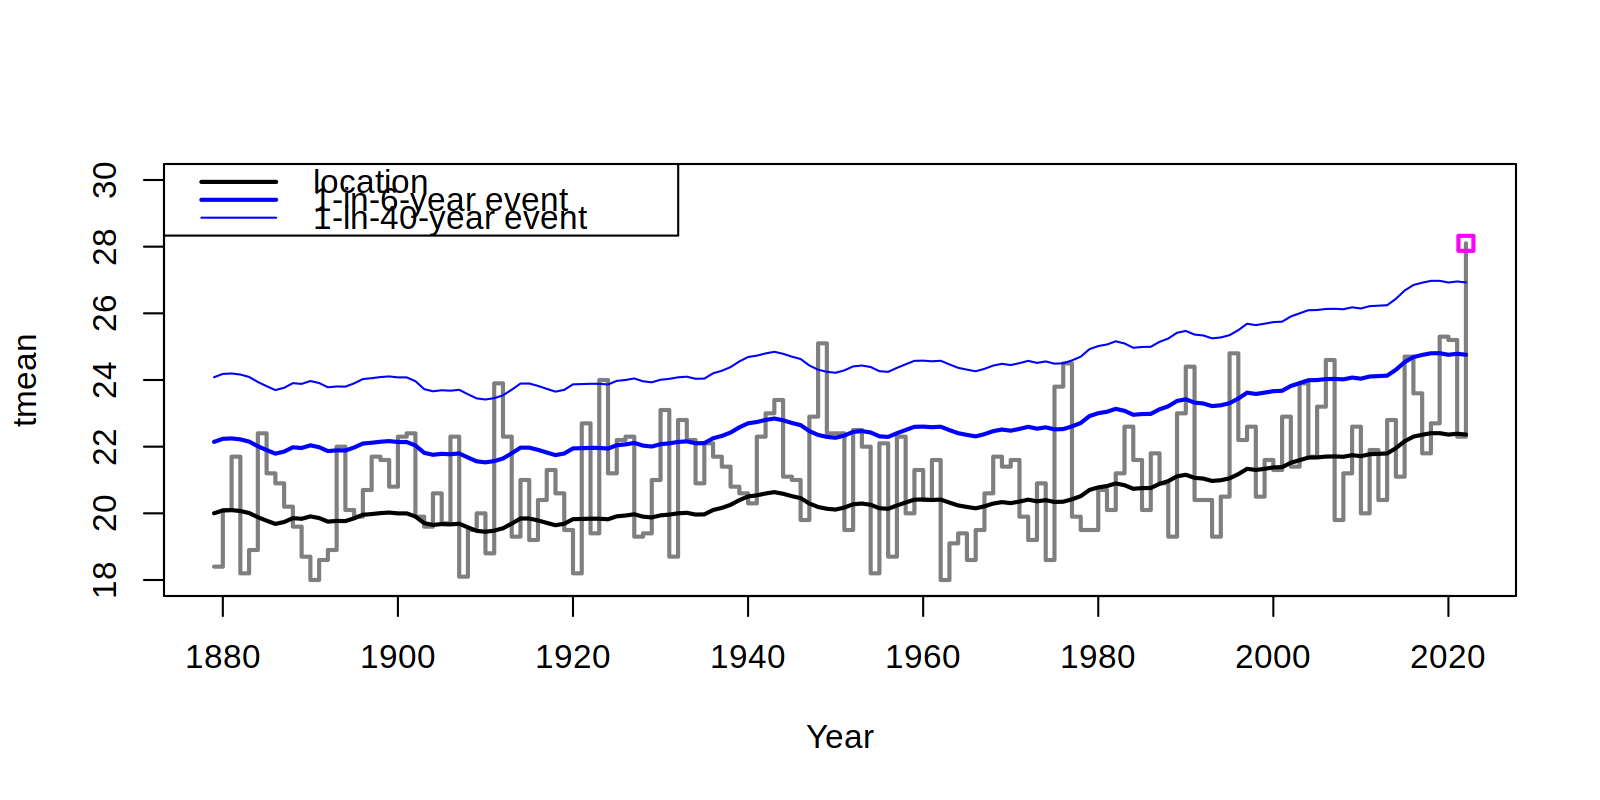

In [31]:
plot_trend(gev_shift)
plot_trend(gev_fd)

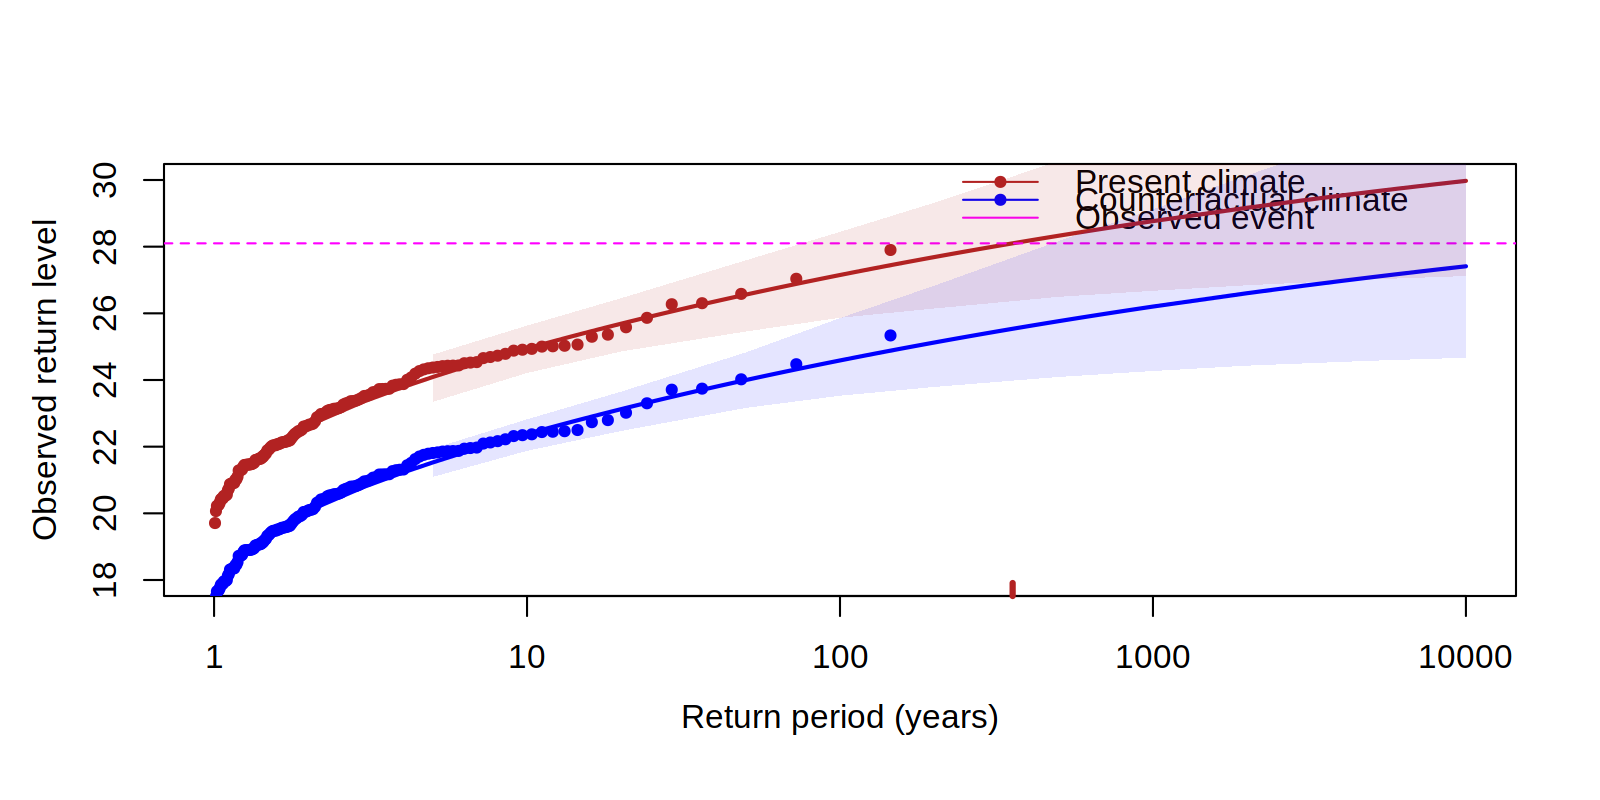

In [35]:
# check goodness of fit: theoretical return period vs observed return level
plot_returnlevels(gev_shift, cov = 1, cov_cf = -0.2, ylab = "Observed return level")

In [36]:
# bootstrap return periods for each observed temperature
set.seed(42)
rp_boot <- abind(sapply(1:1000, function(i) {
            boot_df <- df[sample(1:nrow(df), replace = T),]
            boot_mdl <- fit_ns("gev", "shift", boot_df, "tmean", "gmst", lower = F)
            rbind("f" = sapply(gev_shift$x, function(ev) return_period(boot_mdl, ev, fixed_cov = 1)),
                  "cf" = sapply(gev_shift$x, function(ev) return_period(boot_mdl, ev, fixed_cov = -0.2)))
           }, simplify = F), along = 3)

In [6]:
# get confidence intervals for probability ratio & return periods
pr_ci <- apply(rp_boot[2,,] / rp_boot[1,,], 1, quantile, c(0.025, 0.975), na.rm = T)
pr_ci[!is.finite(pr_ci)] <- 9999

boot_ci <- apply(rp_boot, 1:2, quantile, c(0.025, 0.975), na.rm = T)
boot_ci[!is.finite(boot_ci)] <- 9999

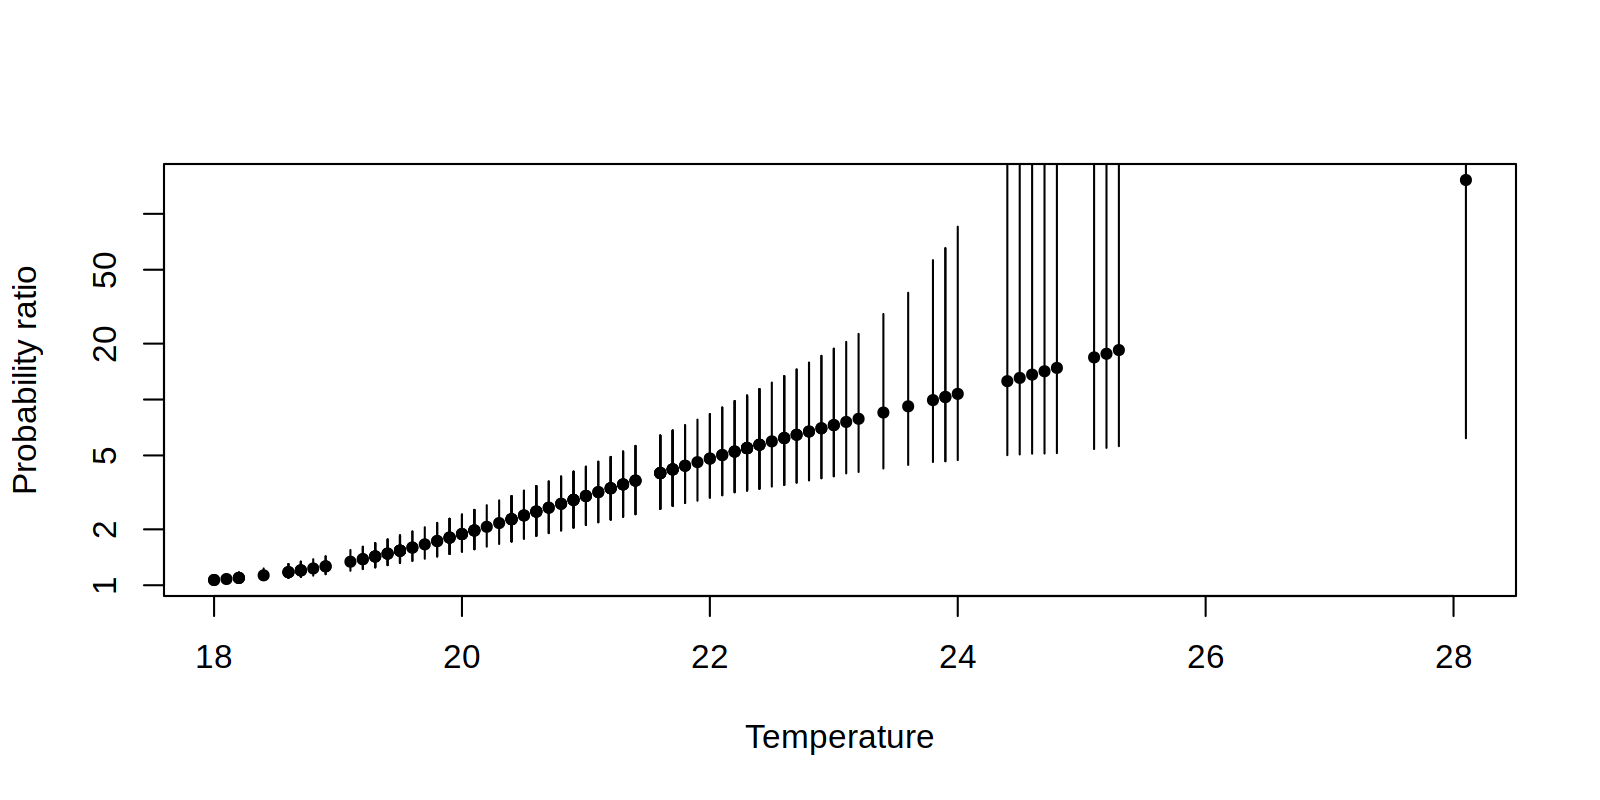

In [7]:
# plot probability ratio & uncertainties
plot(gev_shift$x, sapply(gev_shift$x, function(ev) prob_ratio(gev_shift, ev, 1, -0.2)), log = "y", pch = 20, ylab = "Probability ratio", xlab = "Temperature")
                         
invisible(sapply(1:nrow(df), function(i) lines(rep(gev_shift$x[i], 2), pr_ci[,i])))

In [45]:
# plot return periods in factual & counteractual climates, with uncertainties
plot(sapply(df$tmean, function(ev) return_period(gev_shift, ev, fixed_cov = 1)), df$tmean, log = "x", pch = 20, col = "darkred", xlim = c(0.5, 100000),
            xlab = "Return period", ylab = "Temperature")
            
invisible(sapply(1:nrow(df), function(i) lines(boot_ci[1,,i], rep(df$tmean[i], 2), col = adjustcolor("red", alpha = 0.5))))
points(sapply(df$tmean, function(ev) return_period(gev_shift, ev, fixed_cov = 1)), df$tmean, pch = 20, col = "darkred")

invisible(sapply(1:nrow(df), function(i) lines(boot_ci[2,,i], rep(df$tmean[i], 2), col = adjustcolor("blue", alpha = 0.5))))
points(sapply(df$tmean, function(ev) return_period(gev_shift, ev, fixed_cov = -0.2)), df$tmean, pch = 20, col = "darkblue")
              
legend("bottomright", c("1 degree", "-0.2 degree"), lty = 1, col = c("red", "blue"), pch = 20)

In [68]:
prob_ratio(gev_shift, 23, 1, -0.2)

[1] 7.282131

### **Factual-counterfactual method**

In [46]:
# fit factual & counterfactual models
gev_pres <- fit_ns("gev", "shift", df[df$year >= 1942,], "tmean", "gmst", lower = F)
gev_cf <- fit_ns("gev", "shift", df[df$year <= 1932,], "tmean", "gmst", lower = F)

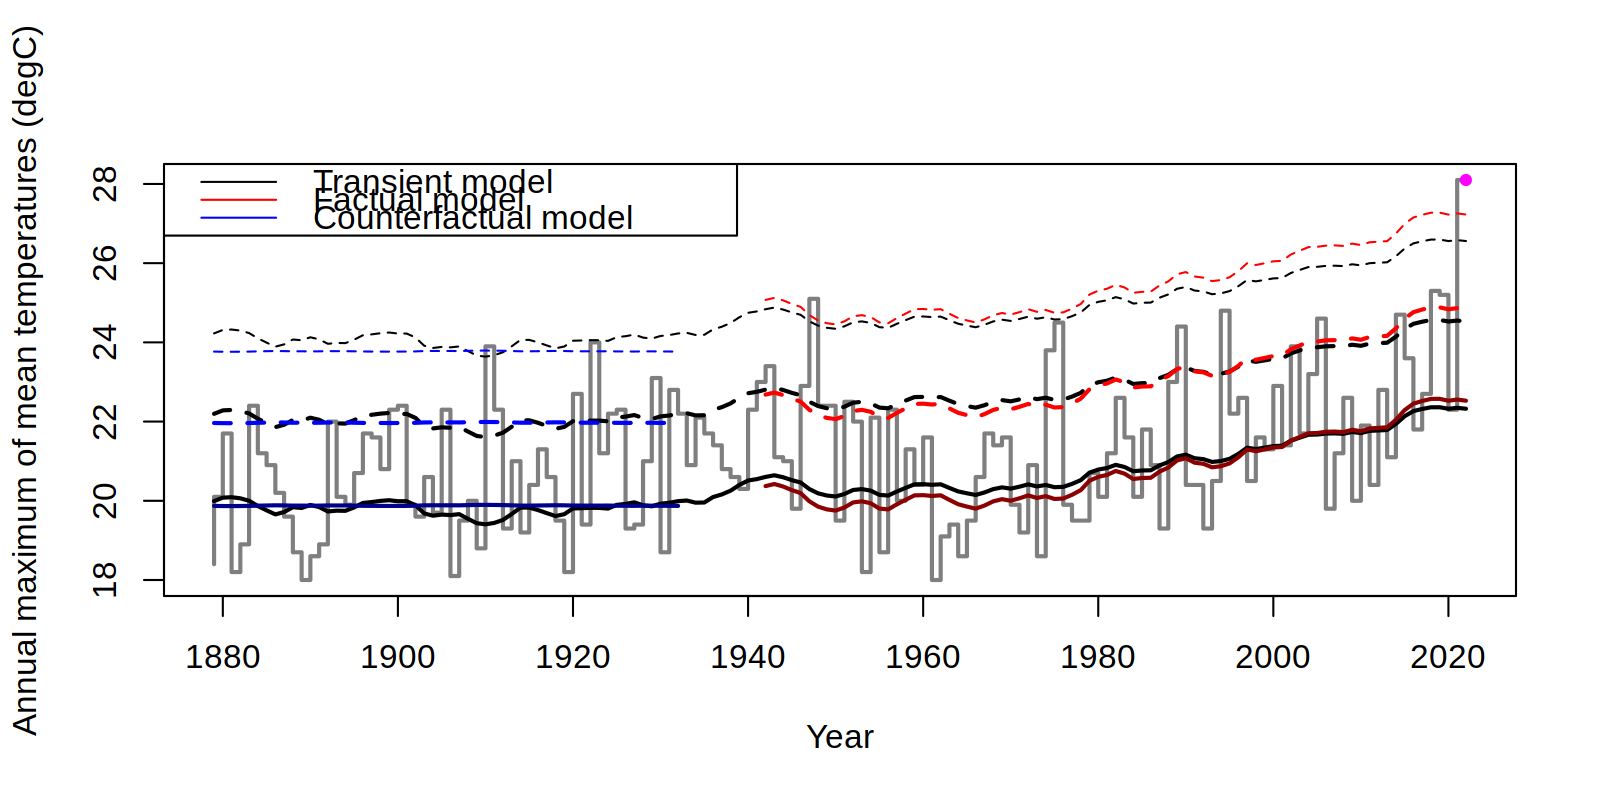

In [47]:
# plot the transient, factual & counterfactual models together

prep_window(c(1,2)); par(mfrow = c(1,1))
plot(df$year, df$tmean, type = "S", lwd = 2, col = adjustcolor("black", alpha = 0.5), xlab = "Year", ylab = "Annual maximum of mean temperatures (degC)")

lines(gev_shift$data$year, ns_pars(gev_shift)$loc, col = "black", lwd = 2)
matplot(gev_shift$data$year, eff_return_level(c(6, 40), gev_shift), type = "l", lty = 2, add = T, col = "black", lwd = c(2,1))

lines(gev_cf$data$year, ns_pars(gev_cf)$loc, col = "darkblue", lwd = 2)
matplot(gev_cf$data$year, eff_return_level(c(6, 40), gev_cf), type = "l", lty = 2, add = T, col = "blue", lwd = c(2,1))

lines(gev_pres$data$year, ns_pars(gev_pres)$loc, col = "darkred", lwd = 2)
matplot(gev_pres$data$year, eff_return_level(c(6, 40), gev_pres), type = "l", lty = 2, add = T, col = "red", lwd = c(2,1))

points(2022, df$tmean[df$year == 2022], col = "magenta", pch = 20)

legend("topleft", c("Transient model", "Factual model", "Counterfactual model"), col = c("black", "red", "blue"), lty = 1)

In [48]:
# bootstrap return periods for observed temperatures under both models

set.seed(42)
boot_rp_pres <- sapply(1:1000, function(i) {
   
    boot_df_pres <- gev_pres$data[sample(1:nrow(gev_pres$data), replace = T),]
    boot_mdl_pres <- fit_ns("gev", "shift", boot_df_pres, "tmean", "gmst", lower = F)
    
    sapply(df$tmean, function(ev) return_period(boot_mdl_pres, ev, fixed_cov = 1))
})
    
set.seed(42)
boot_rp_cf <- sapply(1:1000, function(i) {

    boot_df_cf <- gev_cf$data[sample(1:nrow(gev_cf$data), replace = T),]
    boot_mdl_cf <- fit_ns("gev", "shift", boot_df_cf, "tmean", "gmst", lower = F)
    
    sapply(df$tmean, function(ev) return_period(boot_mdl_cf, ev, fixed_cov = -0.2))
})

In [12]:
# estimate confidence intervals
rp_pres_ci <- apply(boot_rp_pres, 1, quantile, c(0.025, 0.975), na.rm = T)
rp_pres_ci[!is.finite(rp_pres_ci)] <- 9999

rp_cf_ci <- apply(boot_rp_cf, 1, quantile, c(0.025, 0.975), na.rm = T)
rp_cf_ci[!is.finite(rp_cf_ci)] <- 9999

pr_cf_ci <- apply(boot_rp_cf / boot_rp_pres, 1, quantile, c(0.025, 0.975), na.rm = T)
pr_cf_ci[!is.finite(pr_cf_ci)] <- 1e07

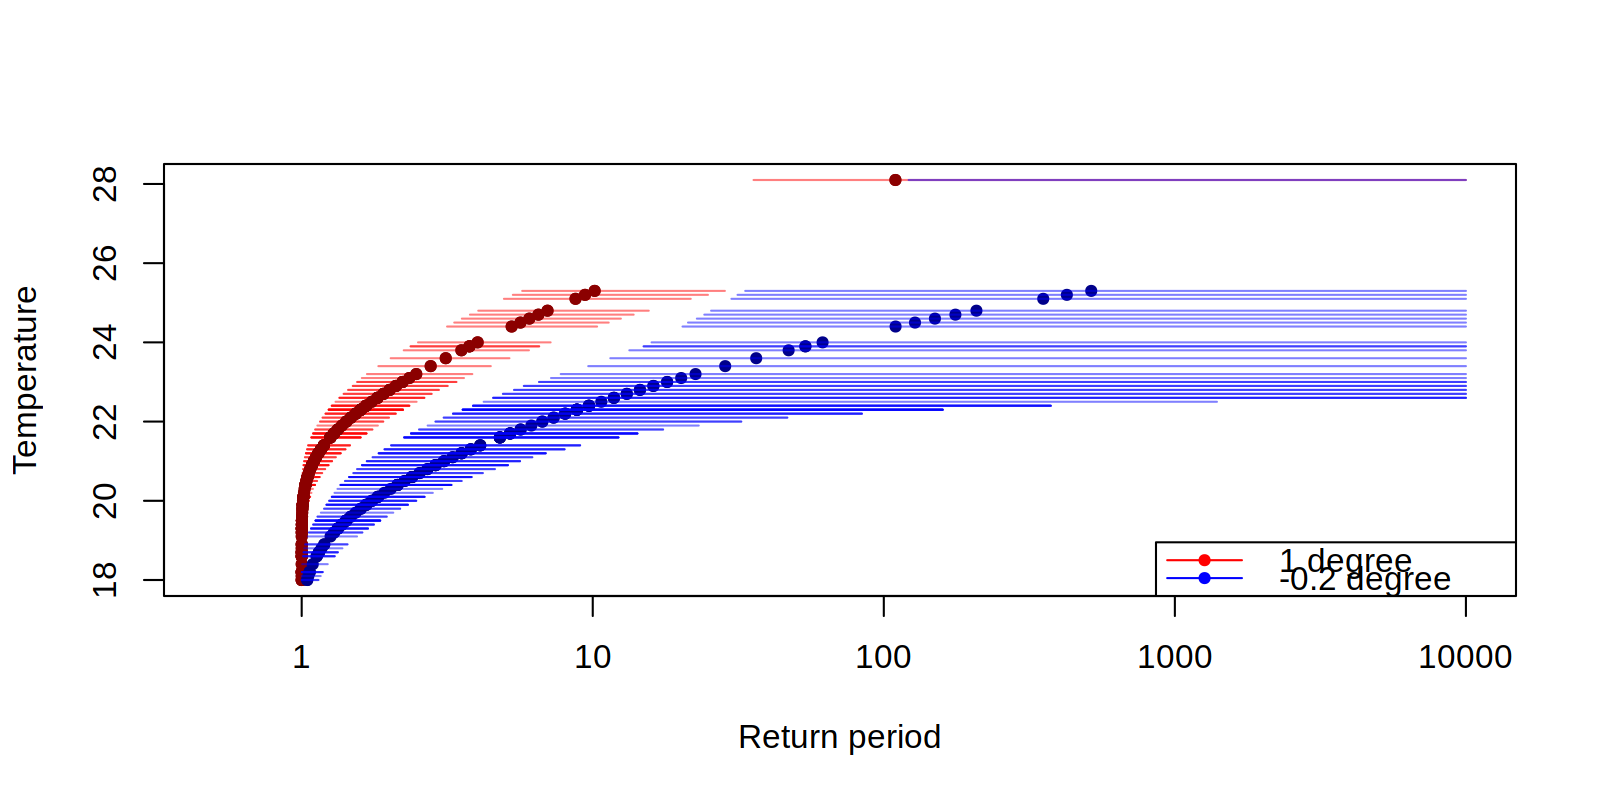

In [18]:
# plot return period in factual & counterfactual models
plot(sapply(df$tmean, function(ev) return_period(gev_pres, ev, fixed_cov = 1)), df$tmean, log = "x", pch = 20, col = "darkred", xlim = c(0.5, 10000),
            xlab = "Return period", ylab = "Temperature")
            
invisible(sapply(1:nrow(df), function(i) lines(rp_pres_ci[,i], rep(df$tmean[i], 2), col = adjustcolor("red", alpha = 0.5))))
points(sapply(df$tmean, function(ev) return_period(gev_pres, ev, fixed_cov = 1)), df$tmean, pch = 20, col = "darkred")

points(sapply(df$tmean, function(ev) return_period(gev_cf, ev, fixed_cov = 1)), df$tmean, pch = 20, col = "darkblue")
invisible(sapply(1:nrow(df), function(i) lines(rp_cf_ci[,i], rep(df$tmean[i], 2), col = adjustcolor("blue", alpha = 0.5))))
                 
legend("bottomright", c("1 degree", "-0.2 degree"), lty = 1, col = c("red", "blue"), pch = 20)

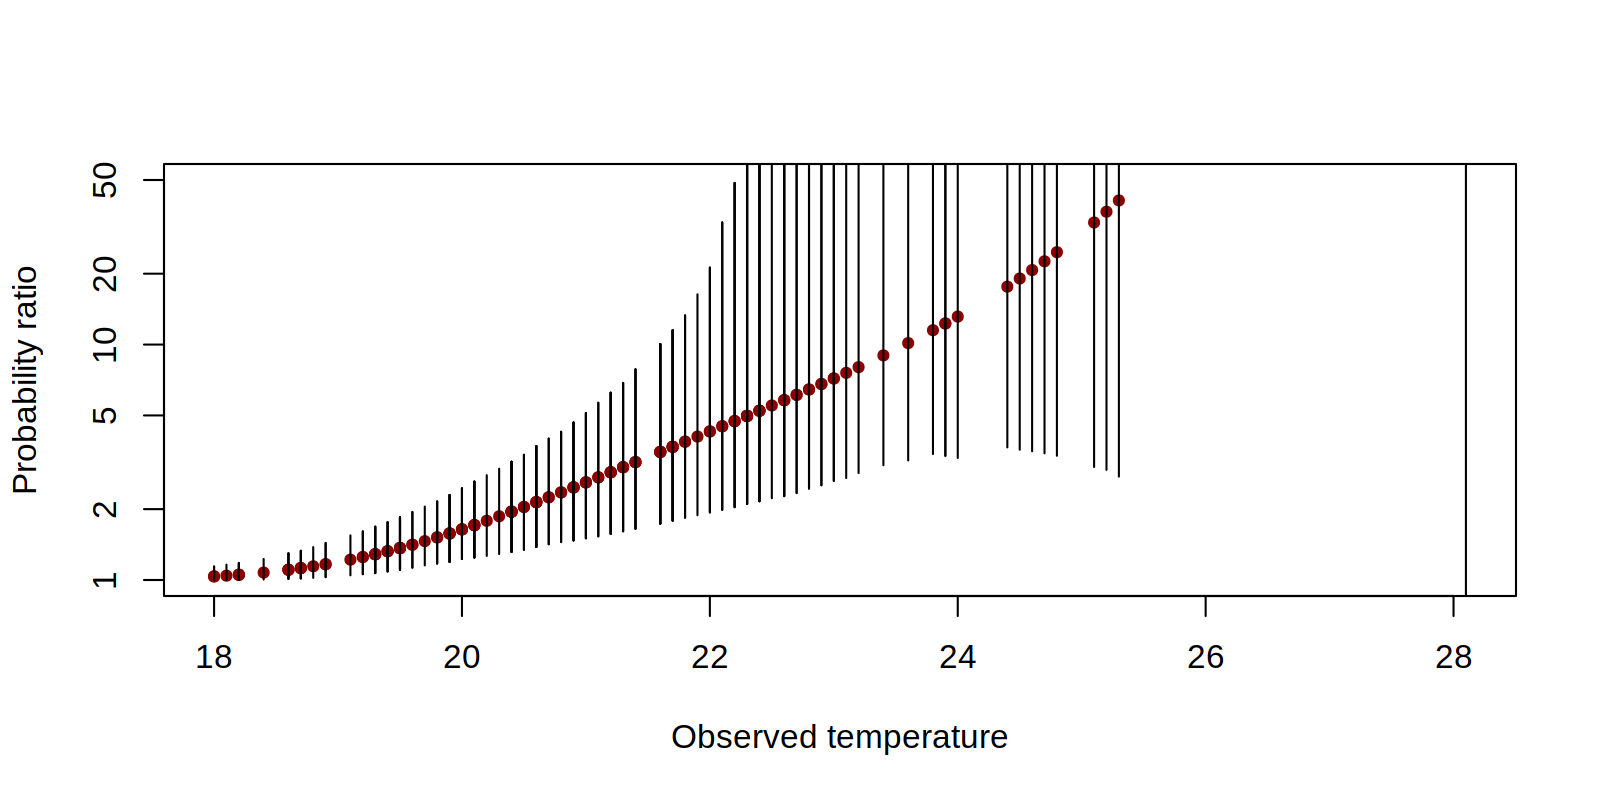

In [65]:
# probability ratio in factual-counterfactual model
plot(df$tmean, sapply(df$tmean, function(ev) return_period(gev_cf, ev, fixed_cov = -0.2) / return_period(gev_pres, ev, fixed_cov = 1)), log = "y", pch = 20, col = "darkred", ylim = c(1,50),
                      xlab = "Observed temperature", ylab = "Probability ratio")
                                               
invisible(sapply(1:nrow(df), function(i) lines(rep(df$tmean[i], 2), pr_cf_ci[,i])))

In [66]:
# probability ratio of exceeding 23 degrees
return_period(gev_cf, 23, fixed_cov = -0.2) / return_period(gev_pres, 23, fixed_cov = 1)

[1] 7.176957

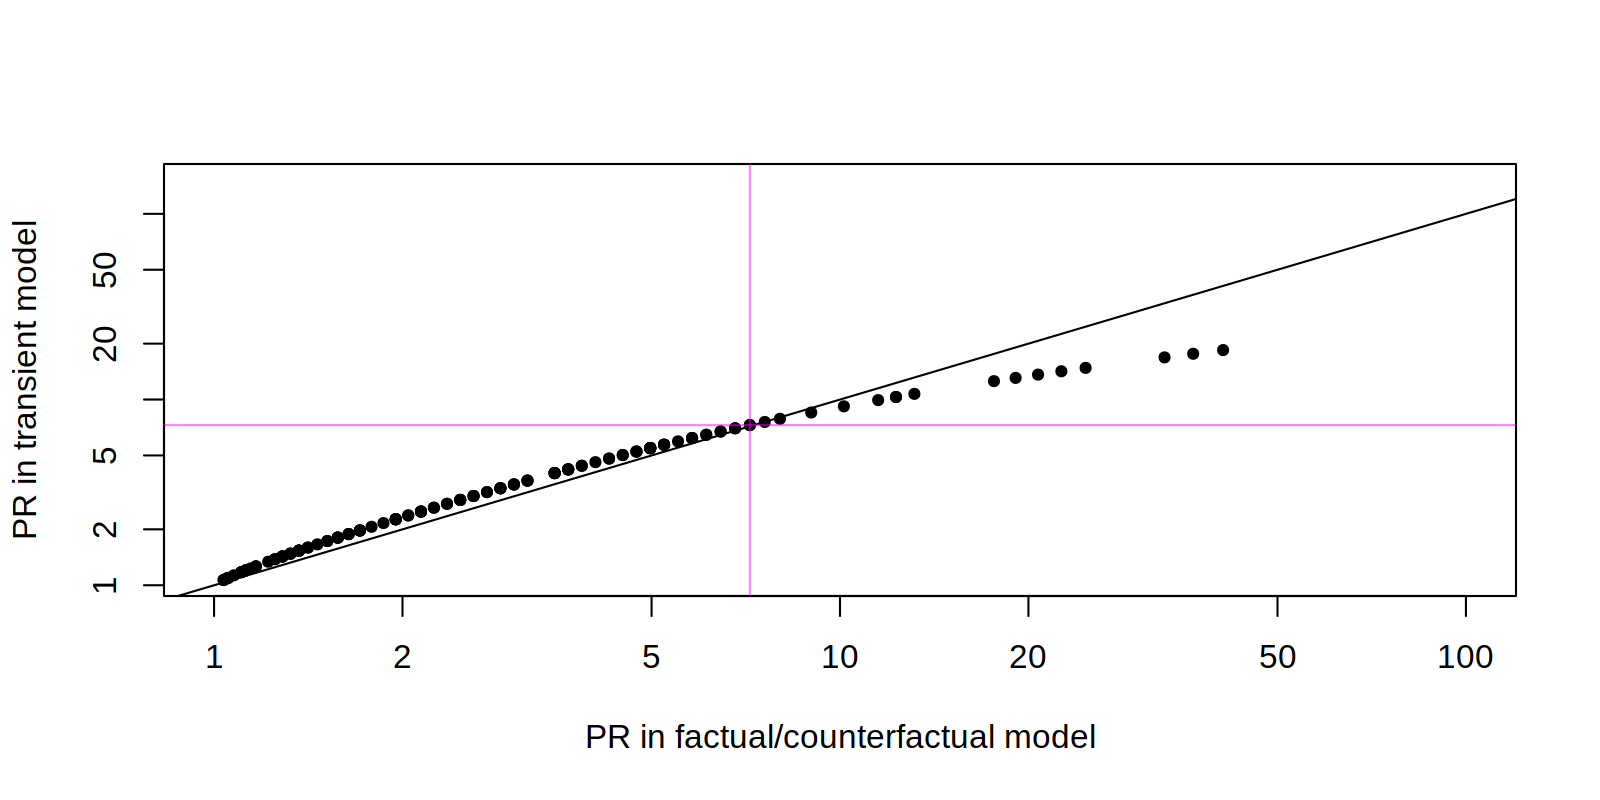

In [73]:
# png("compare-pr.png"); {
    # comparison of probability ratios in the two models
    plot(sapply(df$tmean, function(ev) return_period(gev_cf, ev, fixed_cov = -0.2) / return_period(gev_pres, ev, fixed_cov = 1)),
         sapply(df$tmean, function(ev) prob_ratio(gev_shift, ev, 1, -0.2)), pch = 20, xlab = "PR in factual/counterfactual model", log = "xy", ylab = "PR in transient model", xlim = c(1,100))
    abline(0,1)

    # check change in probability of exceeding 23 degrees under each model
    abline(v = return_period(gev_cf, 23, fixed_cov = -0.2) / return_period(gev_pres, 23, fixed_cov = 1), 
           h = prob_ratio(gev_shift, 23, 1, -0.2), col = adjustcolor("magenta", alpha = 0.5))
# }; dev.off()